### Importing libraries

In [1]:
# pip install tensorflow
# check out https://www.tensorflow.org/tutorials/images/cnn
# can run and compare results in colab

In [2]:
# pip install keras-tuner

In [3]:
# pip install tensorboard
tensorboardPath = "C:/users/npess/appdata/roaming/python/python37/site-packages"

In [4]:
# python C:/users/npess/appdata/roaming/python/python37/site-packages/tensorflow/tensorboard/tensorboard.py --logdir=C:/Capstone/Wildfire_Detection_Capstone_697/logdir

In [5]:
# import tensorflow as tf
# # !pip install -q tf-nightly-2.0-preview
# !pip install tf-nightly-gpu-2.0-preview
# # Load the TensorBoard notebook extension
# %load_ext tensorboard
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [6]:
import os
import pandas as pd
import numpy as np
import itertools

# import required libaries to process images
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline 
import altair as alt
 
#using Keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, preprocessing
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorboard.plugins.hparams import api as hp
# Load the TensorBoard notebook extension
%load_ext tensorboard
%reload_ext tensorboard
# Clear any logs from previous runs
! rm -rf ./logs/
# print("GPU Available: ", tf.config.list_physical_devices('GPU'))

#sklearn
from sklearn.metrics import confusion_matrix

In [7]:
# !pip install -q tf-nightly-2.0-preview
# # Load the TensorBoard notebook extension
# %load_ext tensorboard

In [8]:
# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}

### Importing and examining the images

In [9]:
def resize_image(img):
    width, height = img.size
    ratio = width/height
    new_height = 100
    new_width = int(new_height*ratio)
    img = img.resize((new_width, new_height))
    return img

In [10]:
# follow this on zero padding vs resizing and how it effects accuracy 
# mabye something we talk to Jiaqi about
def pad_images(images, width_max, length_max): 
    padded_images = [] 
    c = 0 
    for image in images: 
        wpad1 = (width_max - image.shape[0])/2
        lpad1 = (length_max - image.shape[1])/2

        if lpad1%1 > 0: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)+1
        else: 
            lpad1 = int(lpad1)
            lpad2 = int(lpad1)

        if wpad1%1 > 0: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)+1
        else: 
            wpad1 = int(wpad1)
            wpad2 = int(wpad1)
        try:
            padded_images.append(np.pad(image, pad_width=[(wpad1 , wpad2),(lpad1, lpad2),(0, 0)], mode='constant'))
        except: 
            print("at {}".format(c))
        c = c + 1
    return padded_images

In [11]:
#crop images to center based on full dataset mean_size
def crop_images(images, width_mean, length_mean):
    train_padded_c = []
    for image in images: 
        
        left = int((image.shape[0] - int(width_mean))/2)
        top = int((image.shape[1] - int(length_mean))/2)
        right = int((image.shape[0] + int(width_mean))/2)
        bottom = int((image.shape[1] + int(length_mean))/2)

        train_padded_c.append(image[left:right, top:bottom])
    return train_padded_c

In [12]:
#checking out the shape for standardization
def shaping (all_images):
    width_means = []
    length_means = []
    for array in all_images:

    #     print(array.shape)

        #width to length ratio
    #     print(array.shape[0]/array.shape[1])

        #width & length means
        width_means.append(array.shape[0])
        length_means.append(array.shape[1])

    width_mean = np.mean(width_means)
    length_mean = np.mean(length_means)

    return None

In [13]:
def get_image_stats(image_arrays):
    widths = [array.shape[0] for array in image_arrays]
    lengths = [array.shape[1] for array in image_arrays]
    width_mean = np.mean(widths)
    length_mean = np.mean(lengths)
    width_max = np.max(widths)
    length_max = np.max(lengths)
    return length_mean, length_max, width_max, width_mean

In [14]:
def load_images2(img_dir, type, height):
    ''' Type as int 0 no_fire 1 fire
        desired height of image as int 
        img_dir as str folder name where images stored'''

    #get list of images 
    dir = os.getcwd()
    rootdir = '{}/assets/{}'.format(dir, img_dir)
    data = []
    try:
        images = os.listdir(rootdir)
        image_file = [file for file in images if '.DS_Store' not in file]
        try:
            image_arrays = [np.asarray(resize_image(Image.open(f'{rootdir}/{image}'))) for image in image_file]
            label_arrays = []
            for array in image_arrays:
                label_arrays.append([type])
            image_labels = label_arrays
            data.extend(list(zip(image_arrays, image_labels)))
        except:
            for subpath in os.listdir(rootdir):
                d = os.path.join(rootdir, subpath)
                images = os.listdir(d)
                image_file = [file for file in images if '.DS_Store' not in file]
                try:
                    image_arrays = [np.asarray(resize_image(Image.open(f'{d}/{image}'))) for image in image_file]
                    label_arrays = []
                    for array in image_arrays:
                        label_arrays.append([type])
                    image_labels = label_arrays
                    data.extend(list(zip(image_arrays, image_labels)))
                except:
                    for subpath in os.listdir(d):
                        d2 = os.path.join(d,subpath)
                        images = os.listdir(d2)
                        print('d2 section')
                        image_file = [file for file in images if '.DS_Store' not in file]
                        if len(image_file)>1:
                            try:
                                print('final try')
                                image_arrays = [np.asarray(resize_image(Image.open(f'{d2}/{image}'))) for image in image_file]
                                label_arrays = []
                                for array in image_arrays:
                                    label_arrays.append([type])
                                image_labels = label_arrays
                                data.extend(list(zip(image_arrays, image_labels)))
                                print(data)
                            except:
                                pass
                        else:
                            pass
    except:
        pass
    
    #get_labels
    print('data')
    print(data)

    return data

In [15]:
def load_images(img_dir, type, height, aug=False):
    ''' Type as int 0 no_fire 1 fire
        desired height of image as int 
        img_dir as str folder name where images stored'''

    #get list of images
    if aug:
        image_file = img_dir
        image_arrays = [np.asarray(resize_image(image)) for image in image_file]
    else:
        dir = os.getcwd()
        images = os.listdir('{}/assets/{}'.format(dir, img_dir))
        image_file = [file for file in images if '.DS_Store' not in file]
        image_arrays = [np.asarray(resize_image(Image.open('{}/assets/{}/{}'.format(dir,img_dir, image)))) for image in image_file]
        paths = ['{}/assets/{}/{}'.format(dir,img_dir, image) for image in image_file]
#         print(paths) #for gitignore
    
    #get_labels
    label_arrays = []
    for array in image_arrays:
        label_arrays.append([type])
    image_labels = label_arrays

    data = list(zip(image_arrays, image_labels))

    return data


In [16]:
def storeImgs (datasets,folders,subfolders,smokeTypes,timeOfDay):
    data = []
    for dataset in datasets:
        if dataset.str.contains('-'):
            for smokeType in smokeTypes:
                for time in timeOfDay:
                    data.extend(load_images(f'{dataset}/{smokeType}/{time}', 1, 100))   
        else:
            data.extend(load_images({dataset}, 1, 100))
                

In [17]:
# wildfire_train_set_Unprocessed = load_images2('wildfire_train_set - Unprocessed', 1, 100)
# wildfire_test_set = load_images2('wildfire_test_set', 1, 100)
# mountain_test_set = load_images2('mountain_test_set', 1, 100)

In [17]:
# wildfire_test_set = load_images('wildfire_test_set', 1, 100)
# mountain_test_set = load_images('mountain_test_set', 0, 100)
nofire_unprocessed = load_images('wildfire_train_set - Base Forest - Unprocessed',0,100)
nofire_processed = load_images('wildfire_train_set - Base Forest - Processed',0,100)
smokeTypes = ['Heavy Smoke','Light Smoke']
timeOfDay = ['Night','Day','Morning']

data = []
# data.extend(wildfire_test_set)
# data.extend(mountain_test_set)
data.extend(nofire_unprocessed)
data.extend(nofire_processed)
for smokeType in smokeTypes:
    for time in timeOfDay:
        wildfire_train_set_Unprocessed = load_images(f'wildfire_train_set - Unprocessed/{smokeType}/{time}', 1, 100)
        data.extend(wildfire_train_set_Unprocessed)
        wildfire_train_set_Processed = load_images(f'wildfire_train_set - Processed and Pruned/{smokeType}/{time}', 1, 100)
        data.extend(wildfire_train_set_Processed)
        
print(len(data))

3324


In [18]:
def imageLabelAssembly(data, augment=False):

    images, labels = zip(*data)

    length_mean, length_max, width_max, width_mean = get_image_stats(images)

    #crop and pad images
    images_cropped = pad_images(images, width_max, length_max)
    images_final = crop_images(images_cropped, width_mean, length_mean)

    #convert all imagees to RGB some are ARGB
    images_final = [np.array(Image.fromarray(image).convert('RGB')) for image in images_final]

    if augment:
        data_augmentation = keras.Sequential(
          [
            layers.RandomFlip("vertical",
                              input_shape=input_shape),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
          ])
        
#         # plt.figure(figsize=(10, 10))
#         augmented_images = []
#         augmented_labels = []
#         # for images in train_images:
#         for i in range(len(train_images[:9])):
#             augmented_image = np.array(data_augmentation(tf.convert_to_tensor(images_final[i], dtype=tf.float32)))
#             augmented_label = labels[i]
#             augmented_images.append(data_augmentation(augmented_image))
#             augmented_labels.append(augmented_label)
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(augmented_image).numpy().astype("uint8")
#             plt.axis("off")
            
#         plt.figure(figsize=(10, 10))
#         for i in range(9):
#             augmented_image = data_augmentation(tf.convert_to_tensor(images_final, dtype=tf.float32)[i])
#             ax = plt.subplot(3, 3, i + 1)
#             plt.imshow(augmented_image)
#             plt.axis("off")
    else:
        pass

#     augmented = list(zip(augmented_images, augmented_labels))
    data = list(zip(images_final, labels))
    
    return data

data = imageLabelAssembly(data, augment=False)

In [19]:
def test_train_split(data):
    # randomize the images
    import random 
    random.seed(42)
    random.shuffle(data)

    #split into train, test, dev
    data_len = len(data)
    train, dev, test = np.split(data, [int(data_len*.8),int(data_len*.9)])
    train_images, train_labels = zip(*train)
    dev_images, dev_labels = zip(*dev)
    test_images, test_labels = zip(*test)
    
    return train_images, train_labels, dev_images, dev_labels, test_images, test_labels
train_images, train_labels, dev_images, dev_labels, test_images, test_labels = test_train_split(data)

C:\Users\npess\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [20]:
#normalize the images
train_images, dev_images, test_images = np.array(train_images) / 255.0, \
                                        np.array(dev_images) / 255.0, \
                                        np.array(test_images) / 255.0,

In [21]:
#testing label application
def plot_images(images, labels):
    import math

    p_size = math.floor(math.sqrt(len(images)))

    class_names = ['no_fire','fire']
    plt.figure(figsize=(10,10))
    for i in range(p_size**2):
        plt.subplot(p_size,p_size,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i][0]])
    
# plot_images(train_images, train_labels)
# plot_images(test_images, test_labels)

In [22]:
input_shape = train_images.shape[1:]

In [23]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [24]:
# print(train_images.shape)
# print(np.asarray(train_labels).reshape(-1).shape)

In [25]:
# train_images = tf.data.Dataset.from_tensor_slices((train_images, np.asarray(train_labels).reshape(-1)))
# test_images = tf.data.Dataset.from_tensor_slices((test_images, np.asarray(test_labels).reshape(-1)))

In [26]:
train_images = tf.convert_to_tensor(train_images, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.float32)
test_images = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.float32)

In [29]:
#sample model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))#(100, 163, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 91, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 89, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 44, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 42, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 56448)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                3

In [30]:
#testing model

epochs=10

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
84/84 [==============================] - 34s 399ms/step - loss: 0.5146 - accuracy: 0.7247 - val_loss: 0.2945 - val_accuracy: 0.8498
Epoch 2/10
84/84 [==============================] - 33s 389ms/step - loss: 0.2267 - accuracy: 0.9000 - val_loss: 0.1860 - val_accuracy: 0.9189
Epoch 3/10
84/84 [==============================] - 32s 377ms/step - loss: 0.2111 - accuracy: 0.9131 - val_loss: 0.1933 - val_accuracy: 0.9099
Epoch 4/10
84/84 [==============================] - 30s 363ms/step - loss: 0.1313 - accuracy: 0.9466 - val_loss: 0.1247 - val_accuracy: 0.9550
Epoch 5/10
84/84 [==============================] - 32s 378ms/step - loss: 0.0828 - accuracy: 0.9688 - val_loss: 0.0679 - val_accuracy: 0.9730
Epoch 6/10
84/84 [==============================] - 33s 387ms/step - loss: 0.0529 - accuracy: 0.9831 - val_loss: 0.0876 - val_accuracy: 0.9550
Epoch 7/10
84/84 [==============================] - 34s 405ms/step - loss: 0.0259 - accuracy: 0.9917 - val_loss: 0.0533 - val_accuracy: 0.9850

In [31]:
history_df = pd.DataFrame(history.history).reset_index()
history_df = history_df.rename(columns={'index':'epoch'})
accuracy_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy'])
loss_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
history_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'])

In [32]:
performanceChart = alt.Chart(history_df,title='Model performance').mark_line(size=3).encode(
    x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False,tickCount=10)),
    y=alt.Y('value',axis=alt.Axis(title='Accuracy/Loss',format='%')),
    color=alt.Color('variable',scale=alt.Scale(range=['#6f0000','#696969','#6f0000','#696969']),
    legend=alt.Legend(title=None,labelFont='Cambria',labelColor='#696969',labelFontSize=14))
    ).properties(
    width=800,
    height=300
    ).configure_title(fontSize=30,color='#232b2b',font='Cambria',anchor='start',offset=20
    ).configure_axis(labelColor='#696969',labelFont='Cambria',labelFontSize=14,titleFont='Cambria',titleFontSize=16,titleColor='#696969'
    )#.configure_legend(labelFontStyle='Cambria',labelFontSize=12)

performanceChart

alt.Chart(...)

In [32]:
# accuracy = alt.Chart(accuracy_df).mark_line().encode(
#     x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False)),
#     y=alt.Y('value',axis=alt.Axis(title='Accuracy')),
#     color=alt.Color('variable'))

# loss = alt.Chart(loss_df).mark_line().encode(
#     x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False)),
#     y=alt.Y('value',axis=alt.Axis(title='Loss')),
#     color=alt.Color('variable'))

# alt.vconcat(accuracy,loss)


### Data augmentation

In [33]:
#comment / uncomment layers orrrr iterate through all combinations?
augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
        layers.RandomContrast(1.0, seed=100),
        ]

# tf.keras.layers.Resizing, tf.keras.layers.Rescaling, tf.keras.layers.RandomFlip, and tf.keras.layers.RandomRotation,

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

In [34]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5)
])

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 100, 184, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 100, 184, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 184, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 92, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 92, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 25, 46, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 25, 46, 64)       

In [37]:
epochs = 3
history = model.fit(
  train_images,train_labels,
  validation_data=(test_images, test_labels),
  epochs=epochs
)

Epoch 1/3
84/84 [==============================] - 23s 263ms/step - loss: 0.7596 - accuracy: 0.4866 - val_loss: 0.7007 - val_accuracy: 0.4895
Epoch 2/3
84/84 [==============================] - 23s 274ms/step - loss: 0.6831 - accuracy: 0.5540 - val_loss: 0.6319 - val_accuracy: 0.6246
Epoch 3/3
84/84 [==============================] - 22s 257ms/step - loss: 0.6477 - accuracy: 0.6111 - val_loss: 0.6836 - val_accuracy: 0.5886


In [56]:
def line_chart(history):

    history_df = pd.DataFrame(history.history).reset_index()
    history_df = history_df.rename(columns={'index':'epoch'})
    accuracy_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy'])
    loss_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['loss', 'val_loss'])
    history_df = pd.melt(history_df, id_vars=['epoch'], value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'])

    performanceChart = alt.Chart(history_df,title='Model performance').mark_line(size=3).encode(
        x=alt.X('epoch',axis=alt.Axis(title='Epoch', grid=False,tickCount=10)),
        y=alt.Y('value',axis=alt.Axis(title='Accuracy/Loss',format='%')),
        color=alt.Color('variable',scale=alt.Scale(range=['#6f0000','#696969','#ff7b7b','#999999']),
        legend=alt.Legend(title=None,labelFont='Cambria',labelColor='#696969',labelFontSize=14))
        ).properties(
        width=800,
        height=300
        ).configure_title(fontSize=30,color='#232b2b',font='Cambria',anchor='start',offset=20
        ).configure_axis(labelColor='#696969',labelFont='Cambria',labelFontSize=14,titleFont='Cambria',titleFontSize=16,titleColor='#696969'
        )#.configure_legend(labelFontStyle='Cambria',labelFontSize=12)
    
    #save as png

    return performanceChart

line_chart(history)

alt.Chart(...)

In [41]:
predictions = model.predict(x=test_images, steps=len(test_images), verbose=0)

In [42]:
cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(predictions, axis=-1))

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            verticalalignment='center',
            color="black" if cm[i, j] > thresh else "black")

Confusion matrix, without normalization
[[145  18]
 [119  51]]


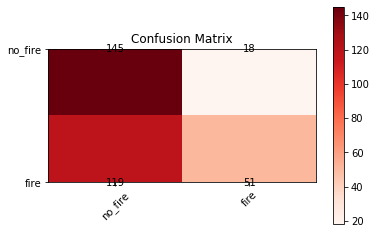

In [46]:
cm_plot_labels = ['no_fire','fire']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Normalized confusion matrix
[[0.88957055 0.11042945]
 [0.7        0.3       ]]


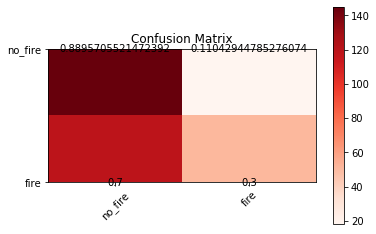

In [47]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, normalize=True, title='Confusion Matrix')

In [48]:
cmDf = pd.DataFrame(cm)
cmDf.columns = ['No fire','Fire']
cmDf.index = ['No fire','Fire']
cmDf.reset_index(inplace=True)
cmDf = cmDf.rename(columns={'index':'Labels'})
cmDf = pd.melt(cmDf, id_vars=['Labels'], value_vars=['No fire','Fire'])
cmDf

,Labels,variable,value
0,No fire,No fire,145
1,Fire,No fire,119
2,No fire,Fire,18
3,Fire,Fire,51


In [49]:
alt.Chart(cmDf).mark_rect().encode(
    x='Labels',
    y='variable',
    color='value'
)

alt.Chart(...)

## Hyperparameter tuning 

### Option 1

In [50]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32, 64])) #8
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'Nadam','RMSprop'])) #'sgd','Adagrad'

METRIC_ACCURACY = 'accuracy'

METRICS = [
    hp.Metric(
        "epoch_accuracy",
        group="validation",
        display_name="accuracy (val.)",
    ),
    hp.Metric(
        "epoch_loss",
        group="validation",
        display_name="loss (val.)",
    ),
    hp.Metric(
        "batch_accuracy",
        group="train",
        display_name="accuracy (train)",
    ),
    hp.Metric(
        "batch_loss",
        group="train",
        display_name="loss (train)",
    ),
]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    metrics=METRICS
    )

In [51]:
#comment / uncomment layers orrrr iterate through all combinations?
augment_layers =[
        layers.RandomFlip("vertical",input_shape=input_shape),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        #other options we can run with.. black and white, saturation, brightness, etc...
#         layers.RandomContrast(1.0, seed=100),
        ]

# tf.keras.layers.Resizing, tf.keras.layers.Rescaling, tf.keras.layers.RandomFlip, and tf.keras.layers.RandomRotation,

def augment (augment_layers):
    return keras.Sequential(augment_layers)

data_augmentation = augment(augment_layers) 

In [52]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [59]:
#https://github.com/tensorflow/tensorboard/blob/master/tensorboard/plugins/hparams/hparams_demo.py#L88

def train_test_model(hparams,epochs,augmentModel=False):
    
    if augmentModel:
        data_augmentation = augment(augment_layers)
    else:
        data_augmentation = ''
    
    
    model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax),
    ])

    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='sparse_categorical_crossentropy',
#       metrics=['accuracy'],
      metrics=['accuracy',f1_m,precision_m, recall_m]
    )
    #############################
    #trying to drill into recall#
    #############################
    
    model.fit(train_images, train_labels, epochs=epochs)
#     history = model.fit(train_images, train_labels, epochs=epochs) # Run with 1 epoch to speed things up for demo purposes
#     _, accuracy = model.evaluate(test_images, test_labels)
    loss, accuracy, f1_score, precision, recall = model.evaluate(test_images, test_labels)
    params.append(hparams)
    losses.append(loss)
    accuracies.append(accuracy)
    f1_scores.append(f1_score)
    precisions.append(precision)
    recalls.append(recall)
#     line_chart(history)
    
    predictions = model.predict(x=test_images, steps=len(test_images), verbose=0)
    cm = confusion_matrix(y_true=test_labels, y_pred=np.argmax(predictions, axis=-1))
    plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

#     tf.print("recall:", type(recall), output_stream=sys.stdout)
    return loss, accuracy, f1_score, precision, recall

def run(run_dir, hparams, epochs, augmentModel=False):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
#         accuracy = train_test_model(hparams,epochs,augmentModel)
#         print(tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1))
#         print(list(tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)))

        model = train_test_model(hparams,epochs,augmentModel=True)
        
        
#         print(tf.summary.scalar(METRIC, accuracy, step=1))
#         print(list(tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)))
#     metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
#     metrics=METRICS
        
    
    
# def run(run_dir, hparams):
#   with tf.summary.create_file_writer(run_dir).as_default():
#     hp.hparams(hparams)  # record the values used in this trial
#     accuracy = create_model(hparams)
#     #converting to tf scalar
#     accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
#     tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

# def run(data, base_logdir, session_id, hparams):
#     """Run a training/validation session.
#     Flags must have been parsed for this function to behave.
#     Args:
#       data: The data as loaded by `prepare_data()`.
#       base_logdir: The top-level logdir to which to write summary data.
#       session_id: A unique string ID for this session.
#       hparams: A dict mapping hyperparameters in `HPARAMS` to values.
#     """
#     model = model_fn(hparams=hparams, seed=session_id)
#     logdir = os.path.join(base_logdir, session_id)

#     callback = tf.keras.callbacks.TensorBoard(
#         logdir,
#         update_freq=flags.FLAGS.summary_freq,
#         profile_batch=0,  # workaround for issue #2084
#     )
#     hparams_callback = hp.KerasCallback(logdir, hparams)
#     ((x_train, y_train), (x_test, y_test)) = data
#     result = model.fit(
#         x=x_train,
#         y=y_train,
#         epochs=flags.FLAGS.num_epochs,
#         shuffle=False,
#         validation_data=(x_test, y_test),
#         callbacks=[callback, hparams_callback],
#     )

# def run_all(logdir, verbose=False):
def run_all(run_dir, verbose=False):
    """Perform random search over the hyperparameter space.
    Arguments:
      logdir: The top-level directory into which to write data. This
        directory should be empty or nonexistent.
      verbose: If true, print out each run's name as it begins.
    """
#     data = prepare_data()
    rng = random.Random(0)

    with tf.summary.create_file_writer(logdir).as_default():
        hp.hparams_config(hparams=HPARAMS, metrics=METRICS)

    sessions_per_group = 2
    num_sessions = flags.FLAGS.num_session_groups * sessions_per_group
    session_index = 0  # across all session groups
    for group_index in range(flags.FLAGS.num_session_groups):
#     for num_units in HP_NUM_UNITS.domain.values:
        hparams = {h: h.domain.sample_uniform(rng) for h in HPARAMS}
        hparams_string = str(hparams)
        for repeat_index in range(sessions_per_group):
            session_id = str(session_index)
            session_index += 1
            if verbose:
                print(
                    "--- Running training session %d/%d"
                    % (session_index, num_sessions)
                )
                print(hparams_string)
                print("--- repeat #: %d" % (repeat_index + 1))
#             run(
#                 data=data,
#                 base_logdir=logdir,
#                 session_id=session_id,
#                 hparams=hparams,
#             )
            run(
                run_dir=run_dir,
                hparams=hparams,
            )
            

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'Nadam'}
Epoch 1/50
84/84 [==============================] - 20s 227ms/step - loss: 0.9338 - accuracy: 0.4949 - f1_m: 0.5875 - precision_m: 0.4695 - recall_m: 0.8168
Epoch 2/50
84/84 [==============================] - 19s 229ms/step - loss: 0.7769 - accuracy: 0.4987 - f1_m: 0.6336 - precision_m: 0.5017 - recall_m: 0.8817
Epoch 3/50
84/84 [==============================] - 19s 227ms/step - loss: 0.7575 - accuracy: 0.5036 - f1_m: 0.6498 - precision_m: 0.5080 - recall_m: 0.9162
Epoch 4/50
84/84 [==============================] - 19s 226ms/step - loss: 0.7411 - accuracy: 0.5359 - f1_m: 0.6549 - precision_m: 0.5153 - recall_m: 0.9327
Epoch 5/50
84/84 [==============================] - 20s 243ms/step - loss: 0.6987 - accuracy: 0.5716 - f1_m: 0.6637 - precision_m: 0.5101 - recall_m: 0.9704
Epoch 6/50
84/84 [==============================] - 19s 228ms/step - loss: 0.6528 - accuracy: 0.6258 - f1_m: 0.6684 - precision_m: 0.

Epoch 1/50
84/84 [==============================] - 19s 220ms/step - loss: 0.8095 - accuracy: 0.4825 - f1_m: 0.6251 - precision_m: 0.4972 - recall_m: 0.8770
Epoch 2/50
84/84 [==============================] - 18s 220ms/step - loss: 0.7263 - accuracy: 0.4964 - f1_m: 0.6523 - precision_m: 0.5051 - recall_m: 0.9438
Epoch 3/50
84/84 [==============================] - 19s 221ms/step - loss: 0.7076 - accuracy: 0.5107 - f1_m: 0.6667 - precision_m: 0.5106 - recall_m: 0.9736
Epoch 4/50
84/84 [==============================] - 19s 220ms/step - loss: 0.6782 - accuracy: 0.5784 - f1_m: 0.6700 - precision_m: 0.5121 - recall_m: 0.9898
Epoch 5/50
84/84 [==============================] - 18s 219ms/step - loss: 0.6352 - accuracy: 0.6296 - f1_m: 0.6699 - precision_m: 0.5110 - recall_m: 0.9952
Epoch 6/50
84/84 [==============================] - 18s 218ms/step - loss: 0.6275 - accuracy: 0.6382 - f1_m: 0.6673 - precision_m: 0.5069 - recall_m: 0.9962
Epoch 7/50
84/84 [==============================] - 18s 22

84/84 [==============================] - 19s 219ms/step - loss: 1.0162 - accuracy: 0.4930 - f1_m: 0.5619 - precision_m: 0.4465 - recall_m: 0.7932
Epoch 2/50
84/84 [==============================] - 18s 220ms/step - loss: 0.7793 - accuracy: 0.5070 - f1_m: 0.6454 - precision_m: 0.5058 - recall_m: 0.9219
Epoch 3/50
84/84 [==============================] - 19s 220ms/step - loss: 0.7491 - accuracy: 0.4994 - f1_m: 0.6607 - precision_m: 0.5085 - recall_m: 0.9639
Epoch 4/50
84/84 [==============================] - 18s 219ms/step - loss: 0.7314 - accuracy: 0.5107 - f1_m: 0.6613 - precision_m: 0.5078 - recall_m: 0.9719
Epoch 5/50
84/84 [==============================] - 18s 219ms/step - loss: 0.7184 - accuracy: 0.5024 - f1_m: 0.6569 - precision_m: 0.5049 - recall_m: 0.9676
Epoch 6/50
84/84 [==============================] - 18s 219ms/step - loss: 0.7191 - accuracy: 0.5039 - f1_m: 0.6636 - precision_m: 0.5112 - recall_m: 0.9655
Epoch 7/50
84/84 [==============================] - 18s 220ms/step - 

84/84 [==============================] - 20s 227ms/step - loss: 0.9206 - accuracy: 0.4840 - f1_m: 0.5895 - precision_m: 0.4672 - recall_m: 0.8245
Epoch 2/50
84/84 [==============================] - 19s 226ms/step - loss: 0.7736 - accuracy: 0.5002 - f1_m: 0.6541 - precision_m: 0.5134 - recall_m: 0.9238
Epoch 3/50
84/84 [==============================] - 19s 227ms/step - loss: 0.7516 - accuracy: 0.4791 - f1_m: 0.6562 - precision_m: 0.5136 - recall_m: 0.9334
Epoch 4/50
84/84 [==============================] - 19s 226ms/step - loss: 0.7239 - accuracy: 0.5092 - f1_m: 0.6577 - precision_m: 0.5129 - recall_m: 0.9407
Epoch 5/50
84/84 [==============================] - 19s 225ms/step - loss: 0.6707 - accuracy: 0.5968 - f1_m: 0.6691 - precision_m: 0.5130 - recall_m: 0.9815
Epoch 6/50
84/84 [==============================] - 19s 226ms/step - loss: 0.6398 - accuracy: 0.6277 - f1_m: 0.6651 - precision_m: 0.5083 - recall_m: 0.9801
Epoch 7/50
84/84 [==============================] - 19s 225ms/step - 

84/84 [==============================] - 19s 221ms/step - loss: 0.8145 - accuracy: 0.4949 - f1_m: 0.6186 - precision_m: 0.4931 - recall_m: 0.8620
Epoch 2/50
84/84 [==============================] - 19s 223ms/step - loss: 0.7315 - accuracy: 0.5092 - f1_m: 0.6521 - precision_m: 0.5079 - recall_m: 0.9302
Epoch 3/50
84/84 [==============================] - 19s 221ms/step - loss: 0.7093 - accuracy: 0.5134 - f1_m: 0.6610 - precision_m: 0.5087 - recall_m: 0.9617
Epoch 4/50
84/84 [==============================] - 19s 222ms/step - loss: 0.6925 - accuracy: 0.5581 - f1_m: 0.6586 - precision_m: 0.5065 - recall_m: 0.9685
Epoch 5/50
84/84 [==============================] - 19s 221ms/step - loss: 0.6356 - accuracy: 0.6382 - f1_m: 0.6676 - precision_m: 0.5084 - recall_m: 0.9921
Epoch 6/50
84/84 [==============================] - 18s 220ms/step - loss: 0.6147 - accuracy: 0.6660 - f1_m: 0.6698 - precision_m: 0.5103 - recall_m: 0.9918
Epoch 7/50
84/84 [==============================] - 19s 223ms/step - 

84/84 [==============================] - 19s 221ms/step - loss: 1.1655 - accuracy: 0.4720 - f1_m: 0.5343 - precision_m: 0.4602 - recall_m: 0.6626
Epoch 2/50
84/84 [==============================] - 18s 219ms/step - loss: 0.8904 - accuracy: 0.4893 - f1_m: 0.6308 - precision_m: 0.5104 - recall_m: 0.8480
Epoch 3/50
84/84 [==============================] - 18s 219ms/step - loss: 0.7996 - accuracy: 0.5085 - f1_m: 0.6349 - precision_m: 0.5134 - recall_m: 0.8691
Epoch 4/50
84/84 [==============================] - 18s 220ms/step - loss: 0.7747 - accuracy: 0.5077 - f1_m: 0.6354 - precision_m: 0.5027 - recall_m: 0.8792
Epoch 5/50
84/84 [==============================] - 18s 219ms/step - loss: 0.7017 - accuracy: 0.5762 - f1_m: 0.6623 - precision_m: 0.5125 - recall_m: 0.9578
Epoch 6/50
84/84 [==============================] - 18s 218ms/step - loss: 0.6527 - accuracy: 0.6281 - f1_m: 0.6651 - precision_m: 0.5116 - recall_m: 0.9681
Epoch 7/50
84/84 [==============================] - 18s 220ms/step - 

84/84 [==============================] - 21s 232ms/step - loss: 0.8368 - accuracy: 0.4904 - f1_m: 0.6165 - precision_m: 0.4763 - recall_m: 0.8907
Epoch 2/50
84/84 [==============================] - 19s 228ms/step - loss: 0.7264 - accuracy: 0.5009 - f1_m: 0.6601 - precision_m: 0.5106 - recall_m: 0.9637
Epoch 3/50
84/84 [==============================] - 19s 228ms/step - loss: 0.6859 - accuracy: 0.5807 - f1_m: 0.6607 - precision_m: 0.5062 - recall_m: 0.9686
Epoch 4/50
84/84 [==============================] - 19s 229ms/step - loss: 0.7180 - accuracy: 0.4810 - f1_m: 0.6698 - precision_m: 0.5122 - recall_m: 0.9896
Epoch 5/50
84/84 [==============================] - 19s 225ms/step - loss: 0.6883 - accuracy: 0.5337 - f1_m: 0.6578 - precision_m: 0.5021 - recall_m: 0.9713
Epoch 6/50
84/84 [==============================] - 19s 229ms/step - loss: 0.6445 - accuracy: 0.6284 - f1_m: 0.6718 - precision_m: 0.5100 - recall_m: 0.9986
Epoch 7/50
84/84 [==============================] - 19s 226ms/step - 

84/84 [==============================] - 19s 222ms/step - loss: 0.8287 - accuracy: 0.4848 - f1_m: 0.6065 - precision_m: 0.4881 - recall_m: 0.8644
Epoch 2/50
84/84 [==============================] - 19s 222ms/step - loss: 0.7161 - accuracy: 0.5039 - f1_m: 0.6474 - precision_m: 0.5052 - recall_m: 0.9368
Epoch 3/50
84/84 [==============================] - 19s 224ms/step - loss: 0.7042 - accuracy: 0.5066 - f1_m: 0.6663 - precision_m: 0.5133 - recall_m: 0.9783
Epoch 4/50
84/84 [==============================] - 19s 224ms/step - loss: 0.7010 - accuracy: 0.4889 - f1_m: 0.6620 - precision_m: 0.5072 - recall_m: 0.9762
Epoch 5/50
84/84 [==============================] - 19s 222ms/step - loss: 0.6970 - accuracy: 0.5141 - f1_m: 0.6700 - precision_m: 0.5137 - recall_m: 0.9867
Epoch 6/50
84/84 [==============================] - 19s 221ms/step - loss: 0.6991 - accuracy: 0.5028 - f1_m: 0.6631 - precision_m: 0.5057 - recall_m: 0.9899
Epoch 7/50
84/84 [==============================] - 18s 220ms/step - 

84/84 [==============================] - 21s 233ms/step - loss: 0.8517 - accuracy: 0.4968 - f1_m: 0.6204 - precision_m: 0.4809 - recall_m: 0.8966
Epoch 2/50
84/84 [==============================] - 20s 235ms/step - loss: 0.7122 - accuracy: 0.4998 - f1_m: 0.6704 - precision_m: 0.5124 - recall_m: 0.9871
Epoch 3/50
84/84 [==============================] - 20s 232ms/step - loss: 0.7145 - accuracy: 0.5036 - f1_m: 0.6662 - precision_m: 0.5128 - recall_m: 0.9796
Epoch 4/50
84/84 [==============================] - 19s 231ms/step - loss: 0.7082 - accuracy: 0.4942 - f1_m: 0.6641 - precision_m: 0.5070 - recall_m: 0.9802
Epoch 5/50
84/84 [==============================] - 19s 231ms/step - loss: 0.7023 - accuracy: 0.4976 - f1_m: 0.6703 - precision_m: 0.5127 - recall_m: 0.9903
Epoch 6/50
84/84 [==============================] - 19s 230ms/step - loss: 0.6856 - accuracy: 0.5592 - f1_m: 0.6671 - precision_m: 0.5082 - recall_m: 0.9912
Epoch 7/50
84/84 [==============================] - 19s 228ms/step - 

84/84 [==============================] - 21s 233ms/step - loss: 0.8827 - accuracy: 0.4961 - f1_m: 0.5974 - precision_m: 0.4726 - recall_m: 0.8329
Epoch 2/50
84/84 [==============================] - 19s 232ms/step - loss: 0.7333 - accuracy: 0.4976 - f1_m: 0.6555 - precision_m: 0.5092 - recall_m: 0.9371
Epoch 3/50
84/84 [==============================] - 20s 233ms/step - loss: 0.7091 - accuracy: 0.5006 - f1_m: 0.6674 - precision_m: 0.5118 - recall_m: 0.9734
Epoch 4/50
84/84 [==============================] - 19s 232ms/step - loss: 0.6989 - accuracy: 0.5201 - f1_m: 0.6634 - precision_m: 0.5085 - recall_m: 0.9795
Epoch 5/50
84/84 [==============================] - 19s 231ms/step - loss: 0.6674 - accuracy: 0.6055 - f1_m: 0.6704 - precision_m: 0.5127 - recall_m: 0.9948
Epoch 6/50
84/84 [==============================] - 19s 231ms/step - loss: 0.6212 - accuracy: 0.6540 - f1_m: 0.6708 - precision_m: 0.5113 - recall_m: 0.9971
Epoch 7/50
84/84 [==============================] - 19s 232ms/step - 

84/84 [==============================] - 20s 227ms/step - loss: 0.8240 - accuracy: 0.4938 - f1_m: 0.6140 - precision_m: 0.4835 - recall_m: 0.8667
Epoch 2/50
84/84 [==============================] - 19s 227ms/step - loss: 0.7274 - accuracy: 0.4983 - f1_m: 0.6599 - precision_m: 0.5081 - recall_m: 0.9639
Epoch 3/50
84/84 [==============================] - 19s 227ms/step - loss: 0.7111 - accuracy: 0.5013 - f1_m: 0.6591 - precision_m: 0.5048 - recall_m: 0.9693
Epoch 4/50
84/84 [==============================] - 19s 228ms/step - loss: 0.7034 - accuracy: 0.4882 - f1_m: 0.6689 - precision_m: 0.5125 - recall_m: 0.9831
Epoch 5/50
84/84 [==============================] - 19s 226ms/step - loss: 0.7002 - accuracy: 0.4968 - f1_m: 0.6659 - precision_m: 0.5084 - recall_m: 0.9886
Epoch 6/50
84/84 [==============================] - 19s 225ms/step - loss: 0.6976 - accuracy: 0.4930 - f1_m: 0.6723 - precision_m: 0.5158 - recall_m: 0.9905
Epoch 7/50
84/84 [==============================] - 19s 227ms/step - 

84/84 [==============================] - 19s 222ms/step - loss: 0.9169 - accuracy: 0.5017 - f1_m: 0.5986 - precision_m: 0.4741 - recall_m: 0.8421
Epoch 2/50
84/84 [==============================] - 19s 221ms/step - loss: 0.7392 - accuracy: 0.4882 - f1_m: 0.6568 - precision_m: 0.5084 - recall_m: 0.9484
Epoch 3/50
84/84 [==============================] - 19s 223ms/step - loss: 0.7145 - accuracy: 0.5006 - f1_m: 0.6607 - precision_m: 0.5084 - recall_m: 0.9690
Epoch 4/50
84/84 [==============================] - 19s 221ms/step - loss: 0.7042 - accuracy: 0.5092 - f1_m: 0.6651 - precision_m: 0.5119 - recall_m: 0.9750
Epoch 5/50
84/84 [==============================] - 19s 221ms/step - loss: 0.7075 - accuracy: 0.4991 - f1_m: 0.6615 - precision_m: 0.5069 - recall_m: 0.9726
Epoch 6/50
84/84 [==============================] - 19s 226ms/step - loss: 0.7027 - accuracy: 0.4930 - f1_m: 0.6657 - precision_m: 0.5099 - recall_m: 0.9818
Epoch 7/50
84/84 [==============================] - 19s 221ms/step - 

84/84 [==============================] - 21s 240ms/step - loss: 0.8439 - accuracy: 0.4855 - f1_m: 0.6117 - precision_m: 0.4756 - recall_m: 0.8935
Epoch 2/50
84/84 [==============================] - 20s 240ms/step - loss: 0.7161 - accuracy: 0.5126 - f1_m: 0.6515 - precision_m: 0.5002 - recall_m: 0.9563
Epoch 3/50
84/84 [==============================] - 20s 239ms/step - loss: 0.6935 - accuracy: 0.5446 - f1_m: 0.6650 - precision_m: 0.5078 - recall_m: 0.9844
Epoch 4/50
84/84 [==============================] - 20s 237ms/step - loss: 0.6488 - accuracy: 0.6168 - f1_m: 0.6688 - precision_m: 0.5093 - recall_m: 0.9898
Epoch 5/50
84/84 [==============================] - 20s 238ms/step - loss: 0.5975 - accuracy: 0.6649 - f1_m: 0.6733 - precision_m: 0.5147 - recall_m: 0.9981
Epoch 6/50
84/84 [==============================] - 20s 238ms/step - loss: 0.5866 - accuracy: 0.6690 - f1_m: 0.6704 - precision_m: 0.5103 - recall_m: 0.9976
Epoch 7/50
84/84 [==============================] - 20s 238ms/step - 

84/84 [==============================] - 20s 230ms/step - loss: 0.7764 - accuracy: 0.5051 - f1_m: 0.6391 - precision_m: 0.4935 - recall_m: 0.9252
Epoch 2/50
84/84 [==============================] - 19s 227ms/step - loss: 0.7006 - accuracy: 0.5325 - f1_m: 0.6637 - precision_m: 0.5070 - recall_m: 0.9809
Epoch 3/50
84/84 [==============================] - 19s 226ms/step - loss: 0.6522 - accuracy: 0.6202 - f1_m: 0.6742 - precision_m: 0.5144 - recall_m: 0.9986
Epoch 4/50
84/84 [==============================] - 19s 225ms/step - loss: 0.6269 - accuracy: 0.6427 - f1_m: 0.6694 - precision_m: 0.5080 - recall_m: 1.0000
Epoch 5/50
84/84 [==============================] - 19s 227ms/step - loss: 0.5988 - accuracy: 0.6732 - f1_m: 0.6725 - precision_m: 0.5110 - recall_m: 0.9994
Epoch 6/50
84/84 [==============================] - 19s 225ms/step - loss: 0.5636 - accuracy: 0.6815 - f1_m: 0.6633 - precision_m: 0.5039 - recall_m: 0.9881
Epoch 7/50
84/84 [==============================] - 19s 225ms/step - 

84/84 [==============================] - 19s 223ms/step - loss: 0.8286 - accuracy: 0.5039 - f1_m: 0.6057 - precision_m: 0.4694 - recall_m: 0.8998
Epoch 2/50
84/84 [==============================] - 19s 223ms/step - loss: 0.7041 - accuracy: 0.5062 - f1_m: 0.6681 - precision_m: 0.5111 - recall_m: 0.9826
Epoch 3/50
84/84 [==============================] - 19s 224ms/step - loss: 0.7036 - accuracy: 0.4942 - f1_m: 0.6703 - precision_m: 0.5106 - recall_m: 0.9904
Epoch 4/50
84/84 [==============================] - 19s 222ms/step - loss: 0.7007 - accuracy: 0.4991 - f1_m: 0.6721 - precision_m: 0.5159 - recall_m: 0.9905
Epoch 5/50
84/84 [==============================] - 19s 223ms/step - loss: 0.6933 - accuracy: 0.5370 - f1_m: 0.6669 - precision_m: 0.5073 - recall_m: 0.9918
Epoch 6/50
84/84 [==============================] - 19s 222ms/step - loss: 0.6500 - accuracy: 0.6138 - f1_m: 0.6707 - precision_m: 0.5112 - recall_m: 0.9995
Epoch 7/50
84/84 [==============================] - 19s 221ms/step - 

84/84 [==============================] - 21s 235ms/step - loss: 0.8307 - accuracy: 0.5073 - f1_m: 0.6205 - precision_m: 0.4909 - recall_m: 0.8966
Epoch 2/50
84/84 [==============================] - 20s 236ms/step - loss: 0.7157 - accuracy: 0.5058 - f1_m: 0.6649 - precision_m: 0.5101 - recall_m: 0.9750
Epoch 3/50
84/84 [==============================] - 20s 234ms/step - loss: 0.7047 - accuracy: 0.5126 - f1_m: 0.6646 - precision_m: 0.5082 - recall_m: 0.9797
Epoch 4/50
84/84 [==============================] - 20s 235ms/step - loss: 0.6814 - accuracy: 0.5656 - f1_m: 0.6694 - precision_m: 0.5109 - recall_m: 0.9870
Epoch 5/50
84/84 [==============================] - 20s 235ms/step - loss: 0.6256 - accuracy: 0.6480 - f1_m: 0.6675 - precision_m: 0.5068 - recall_m: 0.9967
Epoch 6/50
84/84 [==============================] - 20s 234ms/step - loss: 0.6013 - accuracy: 0.6709 - f1_m: 0.6609 - precision_m: 0.5030 - recall_m: 0.9846
Epoch 7/50
84/84 [==============================] - 20s 234ms/step - 

84/84 [==============================] - 21s 242ms/step - loss: 0.7992 - accuracy: 0.4746 - f1_m: 0.6336 - precision_m: 0.4943 - recall_m: 0.9069
Epoch 2/50
84/84 [==============================] - 20s 243ms/step - loss: 0.7093 - accuracy: 0.5107 - f1_m: 0.6604 - precision_m: 0.5060 - recall_m: 0.9748
Epoch 3/50
84/84 [==============================] - 20s 241ms/step - loss: 0.6986 - accuracy: 0.5081 - f1_m: 0.6592 - precision_m: 0.5036 - recall_m: 0.9728
Epoch 4/50
84/84 [==============================] - 20s 241ms/step - loss: 0.6775 - accuracy: 0.5698 - f1_m: 0.6710 - precision_m: 0.5144 - recall_m: 0.9926
Epoch 5/50
84/84 [==============================] - 20s 244ms/step - loss: 0.6340 - accuracy: 0.6322 - f1_m: 0.6696 - precision_m: 0.5077 - recall_m: 1.0000
Epoch 6/50
84/84 [==============================] - 20s 240ms/step - loss: 0.5937 - accuracy: 0.6739 - f1_m: 0.6629 - precision_m: 0.5042 - recall_m: 0.9881
Epoch 7/50
84/84 [==============================] - 20s 241ms/step - 

84/84 [==============================] - 20s 225ms/step - loss: 0.8817 - accuracy: 0.5043 - f1_m: 0.5948 - precision_m: 0.4593 - recall_m: 0.8655
Epoch 2/50
84/84 [==============================] - 19s 225ms/step - loss: 0.7125 - accuracy: 0.5043 - f1_m: 0.6605 - precision_m: 0.5053 - recall_m: 0.9702
Epoch 3/50
84/84 [==============================] - 19s 225ms/step - loss: 0.7011 - accuracy: 0.5024 - f1_m: 0.6676 - precision_m: 0.5085 - recall_m: 0.9865
Epoch 4/50
84/84 [==============================] - 19s 224ms/step - loss: 0.7013 - accuracy: 0.5013 - f1_m: 0.6688 - precision_m: 0.5110 - recall_m: 0.9877
Epoch 5/50
84/84 [==============================] - 19s 226ms/step - loss: 0.6985 - accuracy: 0.5100 - f1_m: 0.6627 - precision_m: 0.5086 - recall_m: 0.9751
Epoch 6/50
84/84 [==============================] - 19s 225ms/step - loss: 0.6989 - accuracy: 0.5021 - f1_m: 0.6697 - precision_m: 0.5135 - recall_m: 0.9849
Epoch 7/50
84/84 [==============================] - 19s 224ms/step - 

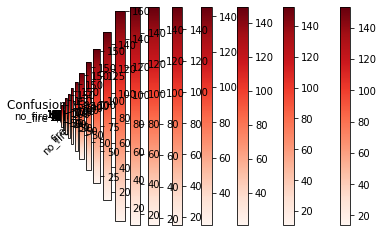

In [60]:
session_num = 0
epochs = 50

# epochs = 30
#{'num_units': 64, 'dropout': 0.2, 'optimizer': 'RMSprop'} 84/89
#{'num_units': 64, 'dropout': 0.2, 'optimizer': 'Nadam'} 84/84
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'RMSprop'} 84/90
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'adam'} 80/86
#{'num_units': 64, 'dropout': 0.1, 'optimizer': 'Nadam'} 86/88
#{'num_units': 32, 'dropout': 0.2, 'optimizer': 'RMSprop'} 81/86
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'RMSprop'} 85/88
#{'num_units': 32, 'dropout': 0.1, 'optimizer': 'Nadam'} 86/88
#{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'} 80/88
#{'num_units': 16, 'dropout': 0.1, 'optimizer': 'Nadam'} 83/87

params = []
losses = []
accuracies = []
f1_scores = []
precisions = []
recalls = []



for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
#             for metrics in METRICS:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams, epochs, augmentModel=True)
            session_num += 1

In [ ]:
#dataframe assembly for model comparison
#integrate confusion matrices as well

print(params)
print(losses)
print(accuracies)
print(f1_scores)
print(precisions)
print(recalls)

In [59]:
# %tensorboard --logdir logs/hparam_tuning
# docker run -it -p 8888:8888 -p 6006:6006 \
# tensorflow/tensorflow:nightly-py3-jupyter 

### Option 2

In [28]:
input_shape = train_images.shape[1:]
print(input_shape)

(100, 184, 3)


In [29]:
def build_model(hp):
    # create model object
    model = keras.Sequential([
    #adding first convolutional layer    
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        # adding filter size or kernel size
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        #activation function
        activation='relu',
        input_shape=input_shape),
    # adding second convolutional layer 
    keras.layers.Conv2D(
        #adding filter 
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        #adding filter size or kernel size
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        #activation function
        activation='relu'
    ),
    # adding flatten layer    
    keras.layers.Flatten(),
    # adding dense layer    
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    # output layer    
    keras.layers.Dense(10, activation='softmax')
    ])
    #compilation of model
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    model.summary()
    
    return model

In [30]:
#importing random search
from kerastuner import RandomSearch

#creating randomsearch object
tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials = 5)
# search best parameter
tuner.search(train_images,train_labels,epochs=3,validation_data=(train_images,train_labels))

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 32)       896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 180, 32)       9248      
_________________________________________________________________
flatten (Flatten)            (None, 552960)            0         
_________________________________________________________________
dense (Dense)                (None, 32)                17694752  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 17,705,226
Trainable params: 17,705,226
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [31]:
model=tuner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 182, 48)       1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 178, 64)       76864     
_________________________________________________________________
flatten (Flatten)            (None, 1070848)           0         
_________________________________________________________________
dense (Dense)                (None, 32)                34267168  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 34,345,706
Trainable params: 34,345,706
Non-trainable params: 0
_________________________________________________________________


ValueError: Shapes (1070848, 32) and (1076864, 32) are incompatible

In [ ]:
model.fit(test_images,test_labels,
          epochs=10,
          validation_split=0.1,
          initial_epoch=3)
_, accuracy = model.evaluate(test_images, test_labels)
